In [1]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn import preprocessing

import time
import itertools

import pickle

In [2]:
# contingency table (confusion matrix)
def plot_contingency_table(cm, title='Contingency Table',
                           cmap=plt.cm.YlGnBu,
                           actual_class_names=['Class 1', 'Class 2'],
                           cluster_class_names=['Cluster 1', 'Cluster 2']):
    plt.gcf().clear()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)
    plt.show()
    
def k_means_clustering(training_data,
                       target_set,
                       n_clusters=8,
                       random_state=None,
                       max_iter=300,
                       n_init=10,
                       actual_class_names=['Class 1', 'Class 2'],
                       cluster_class_names=['Cluster 1', 'Cluster 2'],
                       show_contin=True):
    start = time.time()
    km = KMeans(n_clusters=n_clusters,random_state=random_state,max_iter=max_iter,n_init=n_init)
    km.fit(training_data)
    print("Finished clustering with %i seeds in %f seconds" % (n_init, time.time()-start))

    contin_matrix = metrics.cluster.contingency_matrix(target_set, km.labels_)
    print("Show Contingency Matrix:")
    
    if show_contin:
        plot_contingency_table(contin_matrix, actual_class_names=actual_class_names, cluster_class_names=cluster_class_names)
    
    print("Report 5 Measures for K-Means Clustering")
    
    homogeneity = metrics.homogeneity_score(target_set, km.labels_)
    completeness = metrics.completeness_score(target_set, km.labels_)
    v_measure = metrics.v_measure_score(target_set, km.labels_)
    adjusted_rand_index = metrics.adjusted_rand_score(target_set, km.labels_)
    adjusted_mutual_info = metrics.adjusted_mutual_info_score(target_set, km.labels_)

    print("Homogeneity Score: %f" % homogeneity)
    print("Completeness Score: %f" % completeness)
    print("V-Measure Score: %f" % v_measure)
    print("Adjusted Rand Index: %f" % adjusted_rand_index)
    print("Adjusted Mutual Information: %f" % adjusted_mutual_info)
    
    results = {
        "homogeneity": homogeneity,
        "completeness": completeness,
        "v_measure": v_measure,
        "adjusted_rand_index": adjusted_rand_index,
        "adjusted_mutual_info": adjusted_mutual_info }
    
    return results, km


def svd_dimension_reduction(training_data, n_components=2):
    start = time.time()
    svd = TruncatedSVD(n_components = n_components)
    svd_dataset = svd.fit_transform(training_data)
    print("SVD complete after %f seconds" % (time.time()-start))
    return svd_dataset , svd

def nmf_dimension_reduction(training_data, n_components=None):
    start = time.time()
    nmf = NMF(n_components=n_components, random_state=0)
    nmf_dataset = nmf.fit_transform(training_data)
    print("NMF complete after %f seconds" % (time.time()-start))
    return nmf_dataset , svd

    
def plot_percent_variance(svd):
    plt.gcf().clear()
    print("Plot Percent of Variance")
    plt.plot(np.cumsum(svd.explained_variance_ratio_[:1000]))
    plt.xlabel("Dimension Index")
    plt.ylabel("Percentage of Total Variance")
    plt.show()    
    
def plot_histogram(method, measure, ydata, x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300'], 
                   height=range(1,10),xtickangle=0):
    plt.gcf().clear()
    fig, ax = plt.subplots()
    ax.set_xticks([i+0.25 for i in height])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in height], ydata, 0.5, align='edge', alpha = 0.8)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(measure+' ('+method+')', fontsize = 18)
    plt.axis([0.5,len(x_labels)+1,0,1])
    
    plt.xticks(rotation=xtickangle)
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()   
    
    
def nonlinear_transformation(data, C=0.01):
    return np.sign(data) * (np.log(np.abs(data) + C) - np.log(C))

def unit_variance_scale(data):
    return preprocessing.scale(data, with_mean=False, with_std=True)

def i_love_graphing_points(k_means_object, clustering_result, ground_truth_dataset, title_name = ''):
    plt.gcf().clear()
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.scatter(x=clustering_result[:,0], y=clustering_result[:,1], c=k_means_object.labels_, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20'),vmin=0, vmax=20, alpha=0.5)    
    ax1.set_title('Clustering Result')

    ax2.scatter(x=clustering_result[:,0], y=clustering_result[:,1], c=ground_truth_dataset, edgecolors='k', linewidth=0.25, s=30, cmap=plt.get_cmap('tab20'),vmin=0, vmax=20, alpha=0.5)
    ax2.set_title('Ground Truth')
    fig.suptitle(f'{title_name} Visualization')
    plt.show()
    # plt.savefig("p4b_vis_nmf_%s.pdf" % normalizer_name)

In [3]:
computer_technology_subclasses = ['comp.graphics',
                                  'comp.os.ms-windows.misc',
                                  'comp.sys.ibm.pc.hardware',
                                  'comp.sys.mac.hardware']

recreational_activity_subclasses = ['rec.autos',
                                    'rec.motorcycles',
                                    'rec.sport.baseball',
                                    'rec.sport.hockey']

categories = computer_technology_subclasses + recreational_activity_subclasses

In [4]:
dataset = fetch_20newsgroups(subset='all',categories=categories, shuffle=True, 
                             random_state=42, remove=('headers', 'footers'))

dataset_binary_target = [0 if t<4 else 1 for t in dataset.target]

In [5]:
# QUESTION 1: Report the dimensions of the TF-IDF matrix you get.

In [6]:
# Generate TF-IDF Data, with min_df=3, removed stop words, no stemming
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Print the shape of the datasets
print("QUESTION 1: Report the dimensions of the TF-IDF matrix you get\n")
print('X_tfidf:',X_tfidf.shape)


QUESTION 1: Report the dimensions of the TF-IDF matrix you get

X_tfidf: (7882, 23522)


In [7]:
# QUESTION 2: Report the contingency table of your clustering result.

In [8]:
# QUESTION 3: Report the 5 measures above for the K-means clustering results you get.

Finished clustering with 30 seeds in 129.128046 seconds
Show Contingency Matrix:


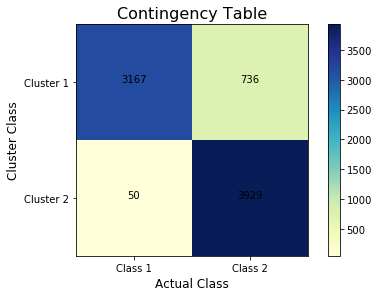

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.580535
Completeness Score: 0.595065
V-Measure Score: 0.587710
Adjusted Rand Index: 0.640848
Adjusted Mutual Information: 0.580496


In [9]:
# Apply K-means clustering with k=2 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.
k_means, km = k_means_clustering(X_tfidf, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)

In [10]:
# QUESTION 4: Report the plot of the percent of variance the top r principle compo-
# nents can retain v.s. r, for r = 1 to 1000.

SVD complete after 18.496878 seconds
Plot Percent of Variance


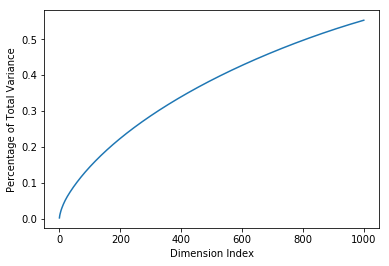

In [11]:
svd_dataset, svd = svd_dimension_reduction(X_tfidf, n_components = 1000)
plot_percent_variance(svd)

In [12]:
# QUESTION 5:
# Let r be the dimension that we want to reduce the data to (i.e. n components).
# Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both
# SVD and NMF.
# Report the best r choice for SVD and NMF respectively.
# Note: what is \best" after all? What if some measures contradict with each other? Here you are faced with this
# challenge that you need to decide which measure you value the most, and design your own standard of \best".
# Please explain your standard and justify it.

n_components: 1
SVD complete after 0.109615 seconds
Finished clustering with 30 seeds in 0.149797 seconds
Show Contingency Matrix:


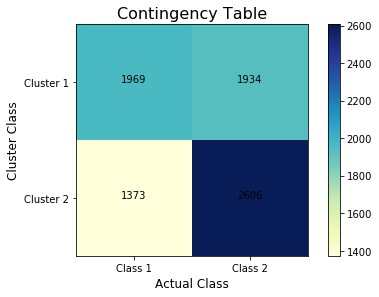

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018850
Completeness Score: 0.019170
V-Measure Score: 0.019009
Adjusted Rand Index: 0.025757
Adjusted Mutual Information: 0.018761
n_components: 2
SVD complete after 0.115148 seconds
Finished clustering with 30 seeds in 0.140077 seconds
Show Contingency Matrix:


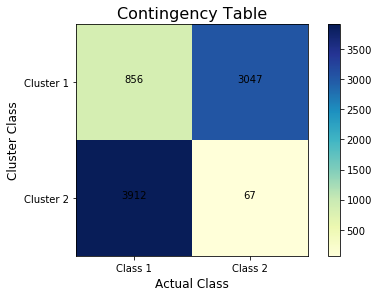

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.529987
Completeness Score: 0.547472
V-Measure Score: 0.538588
Adjusted Rand Index: 0.586391
Adjusted Mutual Information: 0.529944
n_components: 3
SVD complete after 0.110954 seconds
Finished clustering with 30 seeds in 0.154923 seconds
Show Contingency Matrix:


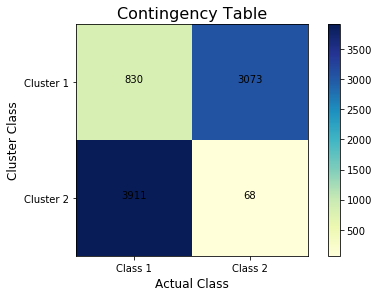

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.537450
Completeness Score: 0.553996
V-Measure Score: 0.545598
Adjusted Rand Index: 0.596148
Adjusted Mutual Information: 0.537408
n_components: 5
SVD complete after 0.137151 seconds
Finished clustering with 30 seeds in 0.206086 seconds
Show Contingency Matrix:


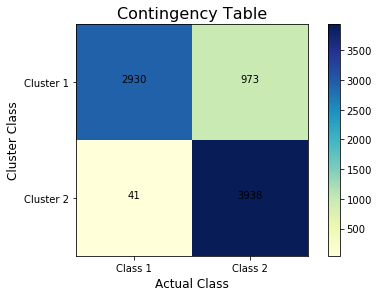

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.512908
Completeness Score: 0.536564
V-Measure Score: 0.524470
Adjusted Rand Index: 0.551555
Adjusted Mutual Information: 0.512864
n_components: 10
SVD complete after 0.175523 seconds
Finished clustering with 30 seeds in 0.255715 seconds
Show Contingency Matrix:


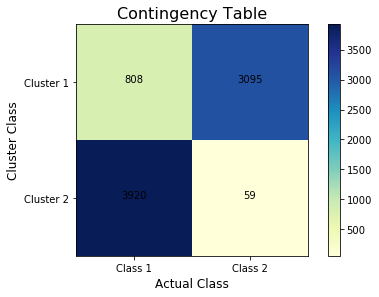

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.550553
Completeness Score: 0.566935
V-Measure Score: 0.558624
Adjusted Rand Index: 0.608359
Adjusted Mutual Information: 0.550512
n_components: 20
SVD complete after 0.292152 seconds
Finished clustering with 30 seeds in 0.323345 seconds
Show Contingency Matrix:


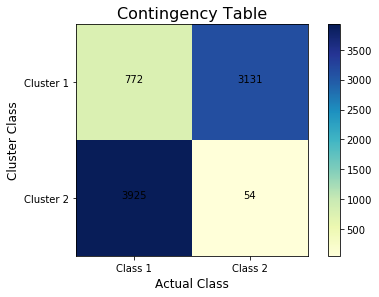

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.565722
Completeness Score: 0.581208
V-Measure Score: 0.573360
Adjusted Rand Index: 0.624698
Adjusted Mutual Information: 0.565682
n_components: 50
SVD complete after 0.612549 seconds
Finished clustering with 30 seeds in 0.596302 seconds
Show Contingency Matrix:


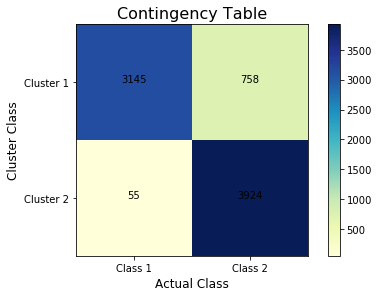

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.569612
Completeness Score: 0.584570
V-Measure Score: 0.576994
Adjusted Rand Index: 0.629925
Adjusted Mutual Information: 0.569573
n_components: 100
SVD complete after 1.125527 seconds
Finished clustering with 30 seeds in 1.283029 seconds
Show Contingency Matrix:


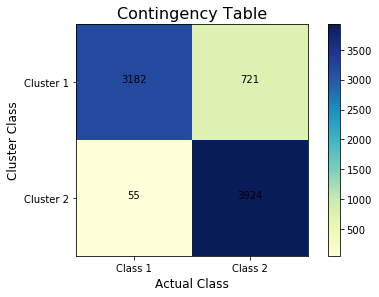

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.581968
Completeness Score: 0.595716
V-Measure Score: 0.588762
Adjusted Rand Index: 0.644918
Adjusted Mutual Information: 0.581930
n_components: 300
SVD complete after 3.222770 seconds
Finished clustering with 30 seeds in 3.951415 seconds
Show Contingency Matrix:


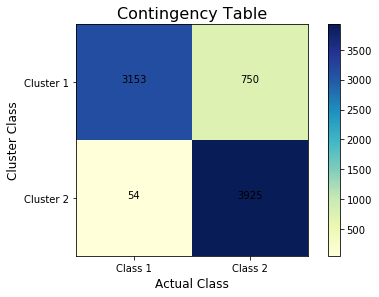

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.572973
Completeness Score: 0.587727
V-Measure Score: 0.580257
Adjusted Rand Index: 0.633555
Adjusted Mutual Information: 0.572934


In [13]:
svd_homogeneity_1 = []
svd_completeness_1 = []
svd_v_measure_1 = []
svd_adjusted_mutual_info_1 = []
svd_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:', r)
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means, km = k_means_clustering(svd_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    svd_homogeneity_1.append(k_means['homogeneity'])
    svd_completeness_1.append(k_means['completeness'])
    svd_v_measure_1.append(k_means['v_measure'])
    svd_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    svd_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


n_components: 1
NMF complete after 0.156047 seconds
Finished clustering with 30 seeds in 0.139401 seconds
Show Contingency Matrix:


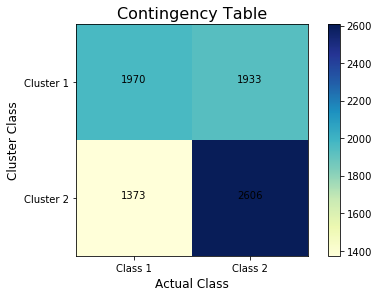

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.018910
Completeness Score: 0.019229
V-Measure Score: 0.019068
Adjusted Rand Index: 0.025839
Adjusted Mutual Information: 0.018820
n_components: 2
NMF complete after 0.317235 seconds
Finished clustering with 30 seeds in 0.112824 seconds
Show Contingency Matrix:


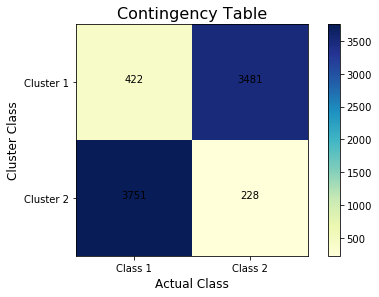

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.592964
Completeness Score: 0.594411
V-Measure Score: 0.593687
Adjusted Rand Index: 0.697299
Adjusted Mutual Information: 0.592927
n_components: 3
NMF complete after 0.501322 seconds
Finished clustering with 30 seeds in 0.118389 seconds
Show Contingency Matrix:


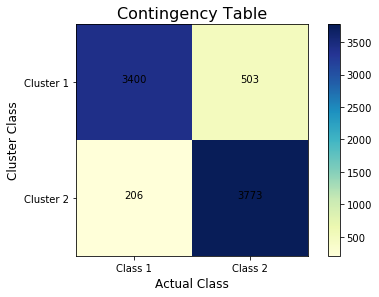

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.571965
Completeness Score: 0.574927
V-Measure Score: 0.573442
Adjusted Rand Index: 0.672517
Adjusted Mutual Information: 0.571926
n_components: 5
NMF complete after 1.811886 seconds
Finished clustering with 30 seeds in 0.170883 seconds
Show Contingency Matrix:


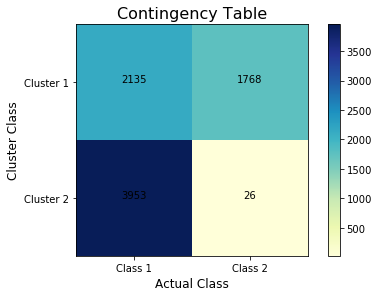

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.253134
Completeness Score: 0.327101
V-Measure Score: 0.285403
Adjusted Rand Index: 0.203906
Adjusted Mutual Information: 0.253065
n_components: 10
NMF complete after 1.149534 seconds
Finished clustering with 30 seeds in 0.225943 seconds
Show Contingency Matrix:


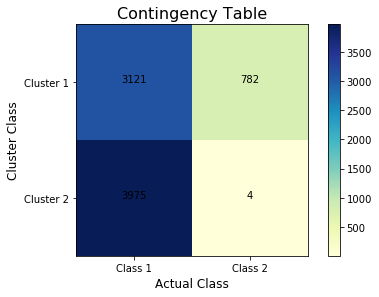

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.104493
Completeness Score: 0.223209
V-Measure Score: 0.142348
Adjusted Rand Index: 0.042771
Adjusted Mutual Information: 0.104411
n_components: 20
NMF complete after 3.245850 seconds
Finished clustering with 30 seeds in 0.302134 seconds
Show Contingency Matrix:


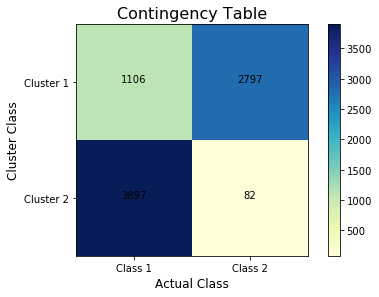

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.448020
Completeness Score: 0.473079
V-Measure Score: 0.460209
Adjusted Rand Index: 0.487914
Adjusted Mutual Information: 0.447969
n_components: 50
NMF complete after 27.602744 seconds
Finished clustering with 30 seeds in 0.588703 seconds
Show Contingency Matrix:


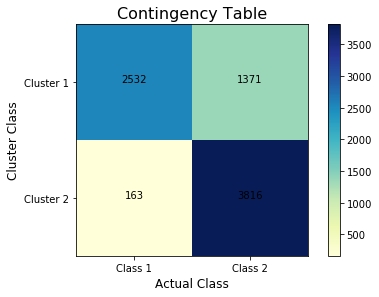

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.339037
Completeness Score: 0.365852
V-Measure Score: 0.351935
Adjusted Rand Index: 0.372949
Adjusted Mutual Information: 0.338976
n_components: 100
NMF complete after 99.814254 seconds
Finished clustering with 30 seeds in 0.677591 seconds
Show Contingency Matrix:


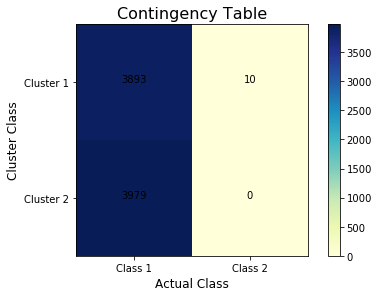

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.001288
Completeness Score: 0.091729
V-Measure Score: 0.002540
Adjusted Rand Index: 0.000055
Adjusted Mutual Information: 0.001191
n_components: 300
NMF complete after 689.772607 seconds
Finished clustering with 30 seeds in 2.649558 seconds
Show Contingency Matrix:


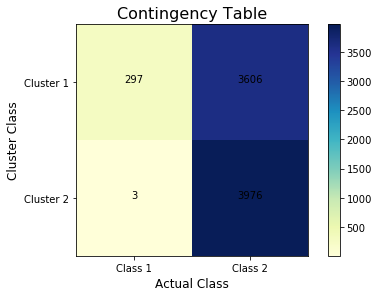

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.036575
Completeness Score: 0.156739
V-Measure Score: 0.059310
Adjusted Rand Index: 0.007000
Adjusted Mutual Information: 0.036486


In [14]:
nmf_homogeneity_1 = []
nmf_completeness_1 = []
nmf_v_measure_1 = []
nmf_adjusted_mutual_info_1 = []
nmf_adjusted_rand_index_1 = []

for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means,km = k_means_clustering(nmf_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
    nmf_homogeneity_1.append(k_means['homogeneity'])
    nmf_completeness_1.append(k_means['completeness'])
    nmf_v_measure_1.append(k_means['v_measure'])
    nmf_adjusted_mutual_info_1.append(k_means['adjusted_mutual_info'])
    nmf_adjusted_rand_index_1.append(k_means['adjusted_rand_index'])
    


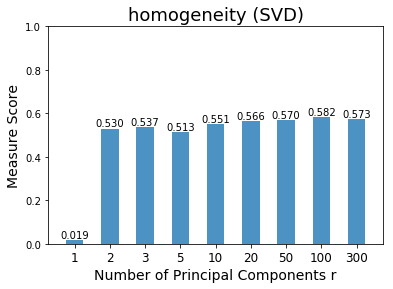

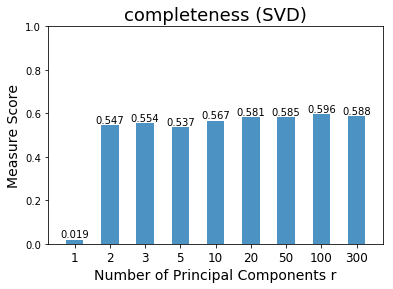

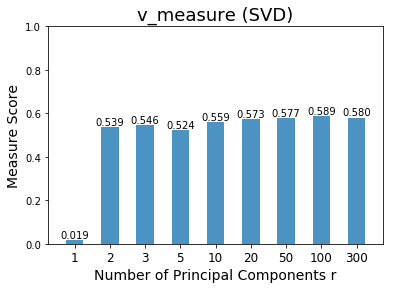

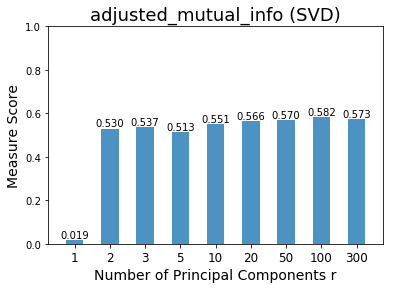

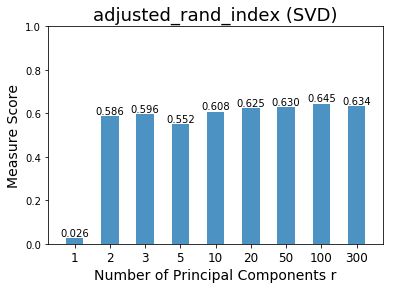

In [15]:
plot_histogram('SVD', 'homogeneity',svd_homogeneity_1)
plot_histogram('SVD', 'completeness',svd_completeness_1)
plot_histogram('SVD', 'v_measure',svd_v_measure_1)
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info_1)
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index_1)
               

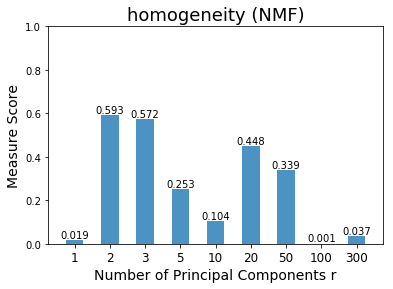

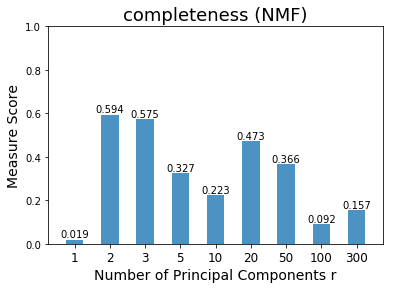

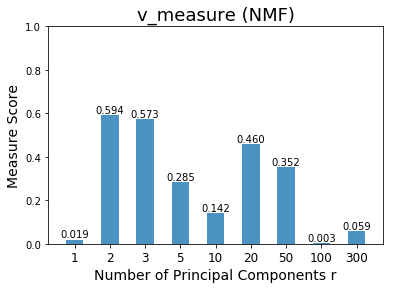

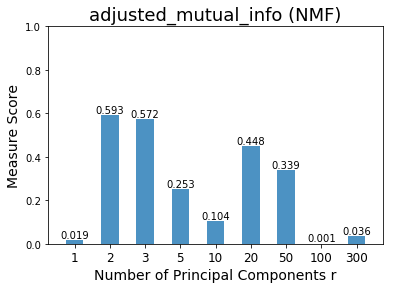

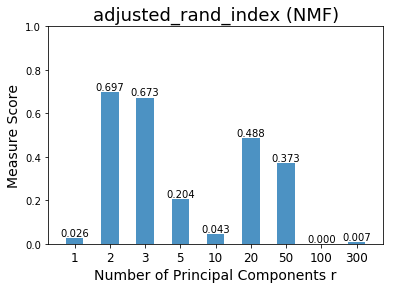

In [16]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity_1)
plot_histogram('NMF', 'completeness',nmf_completeness_1)
plot_histogram('NMF', 'v_measure',nmf_v_measure_1)
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info_1)
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index_1)
               

In [17]:
# QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
# increases?

In [18]:
# QUESTION 7: Visualize the clustering results for:
#  SVD with its best r
#  NMF with its best r

SVD complete after 1.065654 seconds
Finished clustering with 30 seeds in 1.260449 seconds
Show Contingency Matrix:


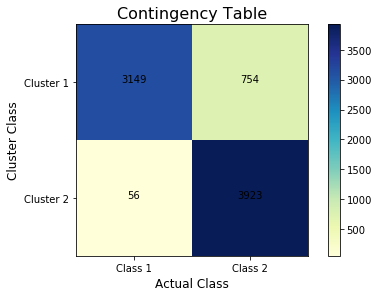

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.570224
Completeness Score: 0.584990
V-Measure Score: 0.577513
Adjusted Rand Index: 0.631134
Adjusted Mutual Information: 0.570185


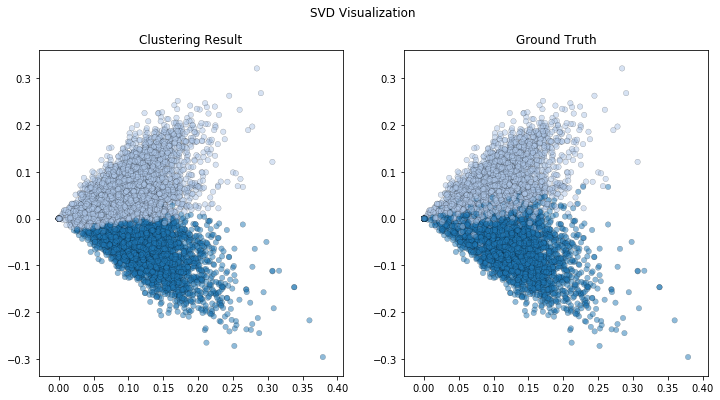

In [19]:
# Best r for SVD is 100
best_svd_dataset,best_svd = svd_dimension_reduction(X_tfidf, n_components = 100)
best_k_means, best_svd_km = k_means_clustering(best_svd_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
i_love_graphing_points(best_svd_km, best_svd_dataset, dataset_binary_target, 'SVD')

NMF complete after 0.320945 seconds
Finished clustering with 30 seeds in 0.118395 seconds
Show Contingency Matrix:


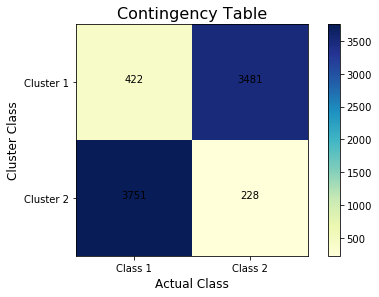

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.592964
Completeness Score: 0.594411
V-Measure Score: 0.593687
Adjusted Rand Index: 0.697299
Adjusted Mutual Information: 0.592927


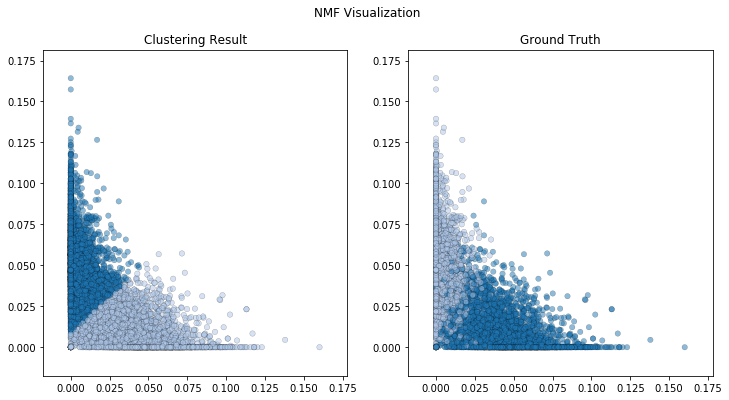

In [20]:
# Best r for NMF is 2
best_nmf_dataset,best_svd = nmf_dimension_reduction(X_tfidf, n_components = 2)
best_k_means, best_nmf_km = k_means_clustering(best_nmf_dataset, dataset_binary_target, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
i_love_graphing_points(best_nmf_km, best_nmf_dataset, dataset_binary_target, 'NMF')

In [21]:
# QUESTIONS 8,9,10

In [22]:
C = 0.01

svd_best_r = 100
nmf_best_r = 2

svd_reduced, svd = svd_dimension_reduction(X_tfidf,svd_best_r)
nmf_reduced, temp = nmf_dimension_reduction(X_tfidf,nmf_best_r)

# for r in [1, 2, 3, 5, 10, 20, 50, 100, 300]:
#     print('n_components:', r)
#     svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
#     k_means = k_means_clustering(svd_dataset, n_clusters=2,random_state=0,max_iter=1000,n_init=30)
#     svd_homogeneity.append(k_means['homogeneity'])
#     svd_completeness.append(k_means['completeness'])
#     svd_v_measure.append(k_means['v_measure'])
#     svd_adjusted_mutual_info.append(k_means['adjusted_mutual_info'])
#     svd_adjusted_rand_index.append(k_means['adjusted_rand_index'])

# Transformations on SVD reduced data
nonlinear_svd = nonlinear_transformation(svd_reduced)
scaled_svd = unit_variance_scale(svd_reduced)
nonlinear_scaled_svd = nonlinear_transformation(unit_variance_scale(svd_reduced))
scaled_nonlinear_svd = unit_variance_scale(nonlinear_transformation(svd_reduced))

# Transformations on NMF reduced data
nonlinear_nmf = nonlinear_transformation(nmf_reduced)
scaled_nmf = unit_variance_scale(nmf_reduced)
nonlinear_scaled_nmf = nonlinear_transformation(unit_variance_scale(nmf_reduced))
scaled_nonlinear_nmf = unit_variance_scale(nonlinear_transformation(nmf_reduced))

SVD complete after 1.052647 seconds
NMF complete after 0.321769 seconds



Results for Nonlinear SVD
Finished clustering with 30 seeds in 1.293806 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.605598
Completeness Score: 0.610098
V-Measure Score: 0.607840
Adjusted Rand Index: 0.698995
Adjusted Mutual Information: 0.605561


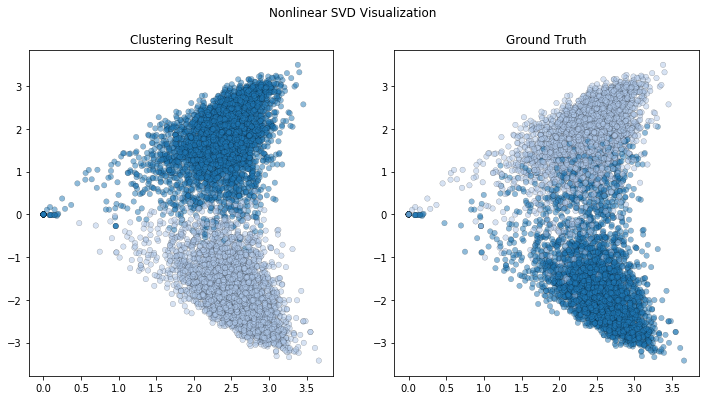


Results for Scaled SVD
Finished clustering with 30 seeds in 1.642826 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.057981
Completeness Score: 0.060963
V-Measure Score: 0.059434
Adjusted Rand Index: 0.074984
Adjusted Mutual Information: 0.057895


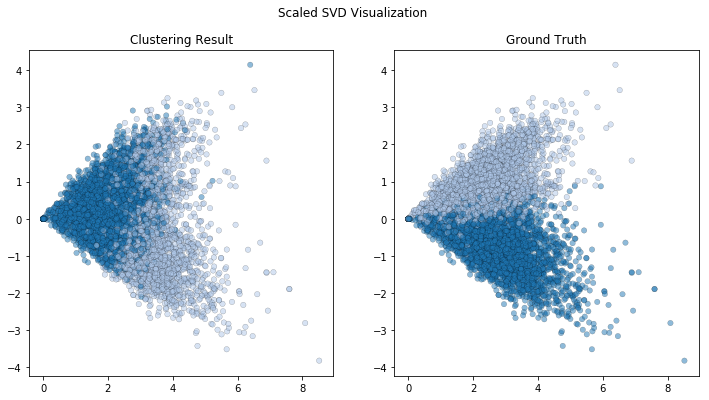


Results for Nonlinear of scaled SVD
Finished clustering with 30 seeds in 2.983059 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.182425
Completeness Score: 0.194766
V-Measure Score: 0.188394
Adjusted Rand Index: 0.213407
Adjusted Mutual Information: 0.182350


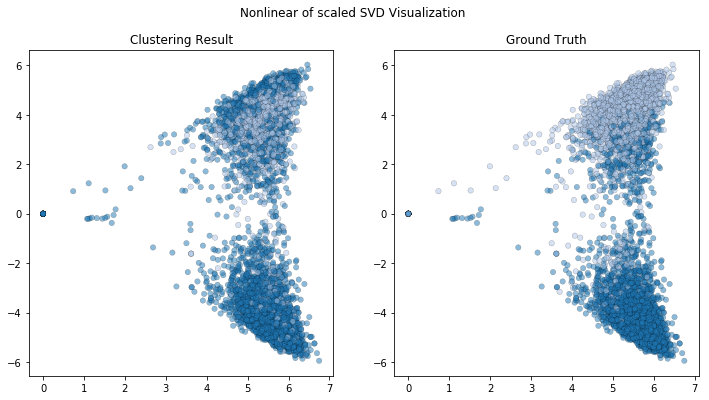


Results for Scaled nonlinear SVD
Finished clustering with 30 seeds in 2.476167 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.003256
Completeness Score: 0.003259
V-Measure Score: 0.003257
Adjusted Rand Index: 0.004327
Adjusted Mutual Information: 0.003164


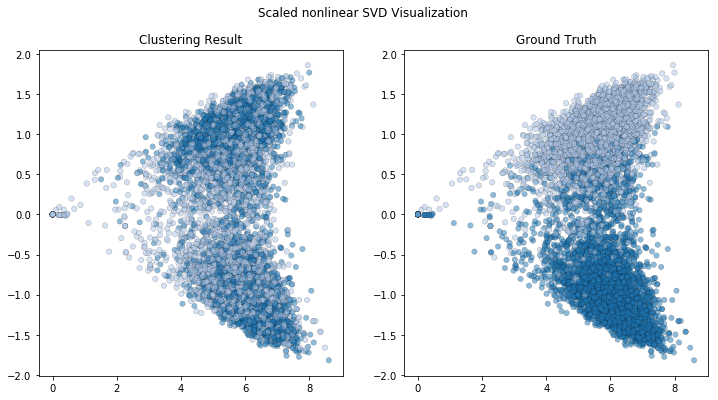


Results for Nonlinear NMF
Finished clustering with 30 seeds in 0.099551 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.603989
Completeness Score: 0.607194
V-Measure Score: 0.605587
Adjusted Rand Index: 0.701969
Adjusted Mutual Information: 0.603953


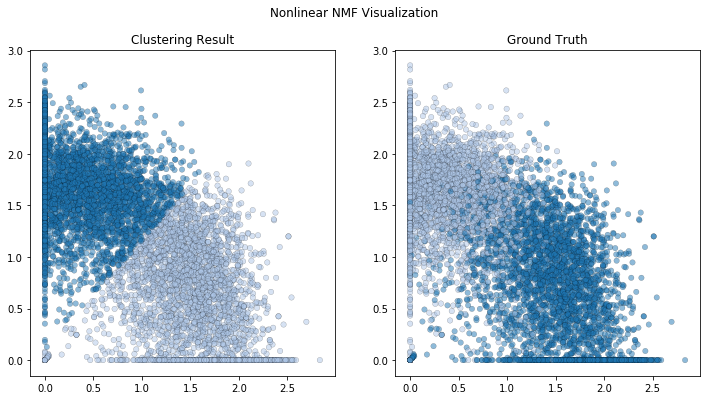


Results for Scaled NMF
Finished clustering with 30 seeds in 0.116302 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.586512
Completeness Score: 0.592994
V-Measure Score: 0.589735
Adjusted Rand Index: 0.674600
Adjusted Mutual Information: 0.586474


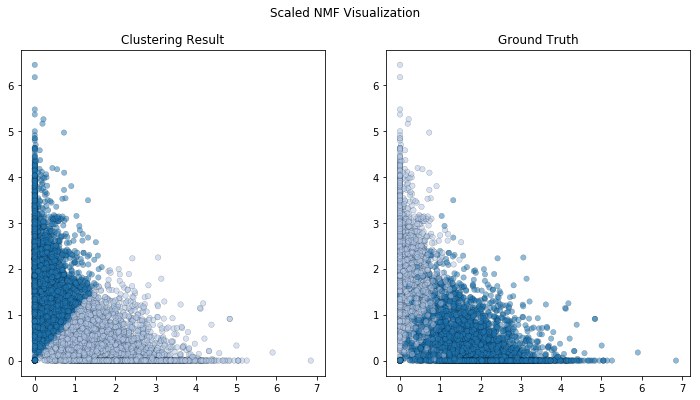


Results for Nonlinear of scaled NMF
Finished clustering with 30 seeds in 0.201216 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.463747
Completeness Score: 0.484032
V-Measure Score: 0.473672
Adjusted Rand Index: 0.503638
Adjusted Mutual Information: 0.463698


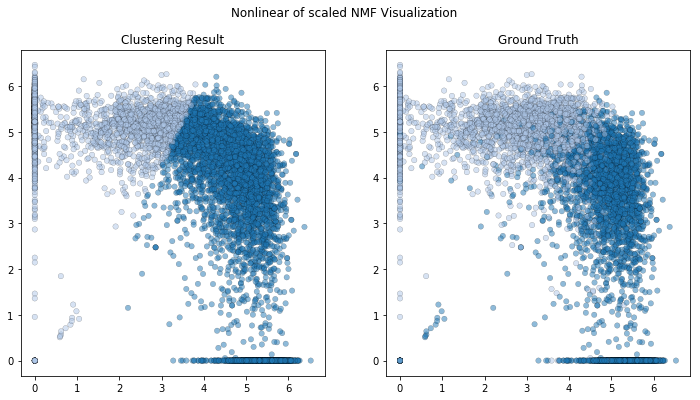


Results for Scaled nonlinear NMF
Finished clustering with 30 seeds in 0.094125 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.597762
Completeness Score: 0.601388
V-Measure Score: 0.599569
Adjusted Rand Index: 0.694758
Adjusted Mutual Information: 0.597726


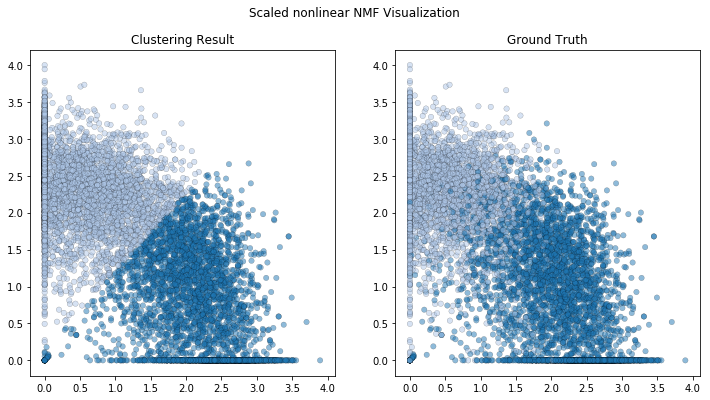

In [23]:
# QUESTION 8: Visualize the transformed data as in part (a).

transformed_labels = ['Nonlinear SVD','Scaled SVD','Nonlinear of scaled SVD', 'Scaled nonlinear SVD',
                     'Nonlinear NMF', 'Scaled NMF','Nonlinear of scaled NMF', 'Scaled nonlinear NMF']

transformed_data = [nonlinear_svd, scaled_svd, nonlinear_scaled_svd, scaled_nonlinear_svd,
                   nonlinear_nmf, scaled_nmf, nonlinear_scaled_nmf, scaled_nonlinear_nmf]

transformed_homogeneity = []
transformed_completeness = []
transformed_v_measure = []
transformed_adj_mutual_info = []
transformed_adj_rand_index = []

# Cluster the transformed data
for i in range(len(transformed_labels)):
    print("\n===============================================")
    print("Results for " + transformed_labels[i])
    print("===============================================")

    results, k_means_object = k_means_clustering(transformed_data[i], dataset_binary_target,
                                 n_clusters=2,random_state=0,max_iter=1000,n_init=30, show_contin=False)
    transformed_homogeneity.append(results['homogeneity'])
    transformed_completeness.append(results['completeness'])
    transformed_v_measure.append(results['v_measure'])
    transformed_adj_mutual_info.append(results['adjusted_mutual_info'])
    transformed_adj_rand_index.append(results['adjusted_rand_index'])
    
    i_love_graphing_points(k_means_object, transformed_data[i], dataset_binary_target, transformed_labels[i])

In [24]:
# QUESTION 9: Can you justify why the \logarithm transformation" may improve the
# clustering results?

In [25]:
# QUESTION 10: Report the new clustering measures (except for the contingency ma-
# trix) for the clustering results of the transformed data.

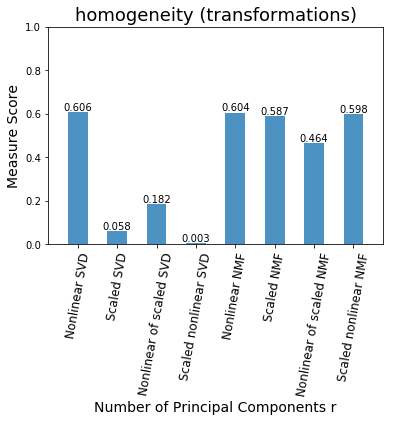

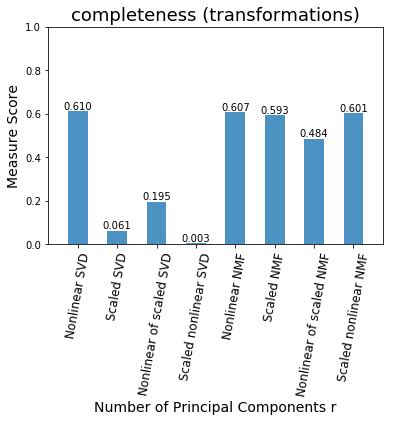

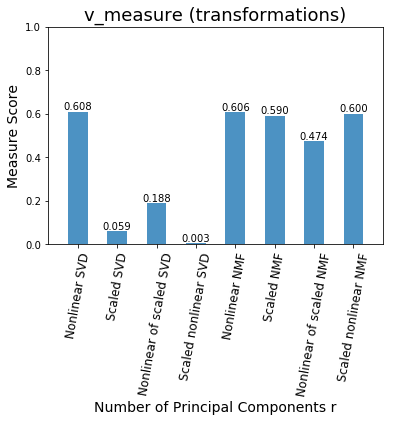

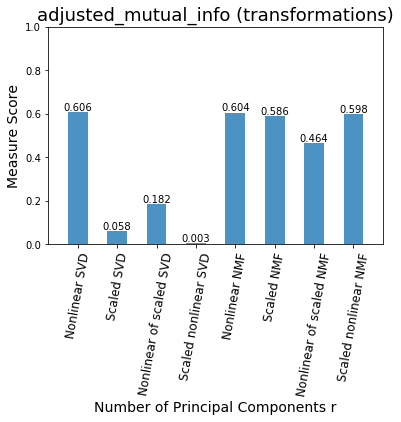

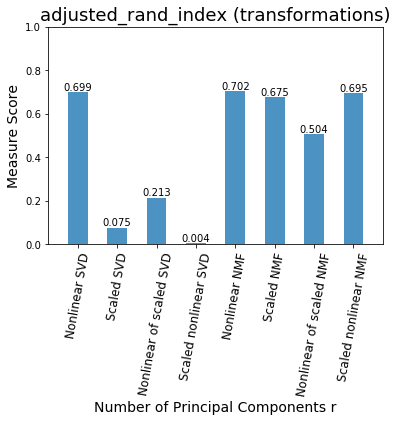

In [26]:
label_rotate_angle = 80
plot_histogram('transformations','homogeneity',transformed_homogeneity,x_labels=transformed_labels,height=range(1,len(transformed_labels)+1),xtickangle=label_rotate_angle)
plot_histogram('transformations','completeness',transformed_completeness,x_labels=transformed_labels,height=range(1,len(transformed_labels)+1),xtickangle=label_rotate_angle)
plot_histogram('transformations','v_measure',transformed_v_measure,x_labels=transformed_labels,height=range(1,len(transformed_labels)+1),xtickangle=label_rotate_angle)
plot_histogram('transformations','adjusted_mutual_info',transformed_adj_mutual_info,x_labels=transformed_labels,height=range(1,len(transformed_labels)+1),xtickangle=label_rotate_angle)
plot_histogram('transformations','adjusted_rand_index',transformed_adj_rand_index,x_labels=transformed_labels,height=range(1,len(transformed_labels)+1),xtickangle=label_rotate_angle)

In [27]:
# QUESTION 11: Repeat the following for 20 categories using the same parameters as in
# 2-class case:
#  Transform corpus to TF-IDF matrix;
#  Directly perform K-means and report the 5 measures and the contingency matrix;

In [28]:
km_20 = pickle.load(open("km_20.pkl","rb"))
km_2 = pickle.load(open("km_2.pkl","rb"))

In [29]:
# pickle.dump(km_2,open("km_2.pkl","wb"))
# pickle.dump(km_20,open("km_20.pkl","wb"))

In [30]:
# # Apply K-means clustering with k=20 using the TF-IDF data. Use random_state=0, max_iter >= 1000, n_init>=30.
# N_CLUSTERS = 20
# RANDOM_STATE = 0
# MAX_ITER = 1000
# N_INIT = 30

# km_20 = k_means_clustering(nmf_dataset, n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)


# # km_20 = KMeans(n_clusters=N_CLUSTERS,random_state=RANDOM_STATE,max_iter=MAX_ITER,n_init=N_INIT)
# # start = time.time()
# # km_20.fit(X_tfidf)
# # print("Finished clustering with %i seeds in %f seconds" % (N_INIT, time.time()-start))

In [31]:
homogeneity = metrics.homogeneity_score(dataset.target, km_20.labels_)
completeness = metrics.completeness_score(dataset.target, km_20.labels_)
v_measure = metrics.v_measure_score(dataset.target, km_20.labels_)
adjusted_rand_index = metrics.adjusted_rand_score(dataset.target, km_20.labels_)
adjusted_mutual_info = metrics.adjusted_mutual_info_score(dataset.target, km_20.labels_)

print("Homogeneity Score: %f" % homogeneity)
print("Completeness Score: %f" % completeness)
print("V-Measure Score: %f" % v_measure)
print("Adjusted Rand Index: %f" % adjusted_rand_index)
print("Adjusted Mutual Information: %f" % adjusted_mutual_info)

Homogeneity Score: 0.500875
Completeness Score: 0.390273
V-Measure Score: 0.438711
Adjusted Rand Index: 0.219522
Adjusted Mutual Information: 0.388325


QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes
 
Contingency Matrix:
[[ 54  47   2   0   0   0  10   0   0   6   8  24   8 406 406   1   0   1
    0   0]
 [ 89  77   0   0  29   4   8   0   0   9  83 372   3  46 241   5   0   3
    0  16]
 [125  38   0   0  16  76  16   0   0  55  10  44 147   5 317   0   0   2
    2 129]
 [ 29  68   0   2  15  29 317   1   0  77  35   6  72   6 234   1   0   1
    0  70]
 [  0 118   0   0   0   0   1   0   0   0   0   2   0   0 209 228 363  67
    0   2]
 [  0 121  28   2   0   0   0   0   0   0   0   0   0   0 144  53  20 624
    1   3]
 [  0 134  13 476   0   0   0  26 108   0   0   0   0   1 197   6   0   5
   28   0]
 [  0 100  78  31   0   0   0 345  45   0   0   0   2   0 113   0   0   4
  281   0]]


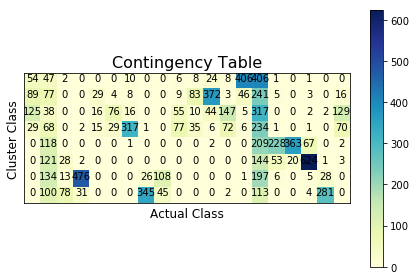

In [32]:
print("QUESTION 11: Report 5 Measures for K-Means Clustering for 20 classes\n ")
contin_matrix = metrics.cluster.contingency_matrix(dataset.target, km_20.labels_)
print("Contingency Matrix:")
print(contin_matrix)
# print_cluster_metrics(dataset.target, km_20)

plot_contingency_table(contin_matrix, actual_class_names=[], cluster_class_names=[])

In [33]:
# QUESTION 12: Try different dimensions for both truncated SVD and NMF dimensionality reduction
# techniques and the different transformations of the obtained feature vectors as
# outlined in above parts.
# You don't need to report everything you tried, which will be tediously long. You are asked,
# however, to report your best combination, and quantitatively report how much better
# it is compared to other combinations. You should also include typical combinations
# showing what choices are desirable (or undesirable).

n_components: 100
SVD complete after 1.107586 seconds
Finished clustering with 5 seeds in 0.470357 seconds
Show Contingency Matrix:


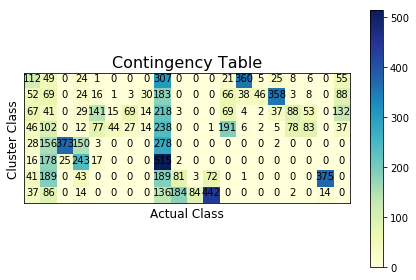

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.387323
Completeness Score: 0.311746
V-Measure Score: 0.345449
Adjusted Rand Index: 0.143757
Adjusted Mutual Information: 0.309467
n_components: 150
SVD complete after 1.616417 seconds
Finished clustering with 5 seeds in 0.709867 seconds
Show Contingency Matrix:


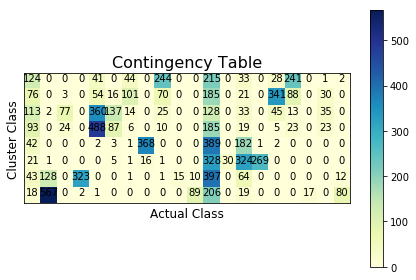

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.440784
Completeness Score: 0.366824
V-Measure Score: 0.400417
Adjusted Rand Index: 0.185519
Adjusted Mutual Information: 0.364620
n_components: 200
SVD complete after 2.102920 seconds
Finished clustering with 5 seeds in 1.005425 seconds
Show Contingency Matrix:


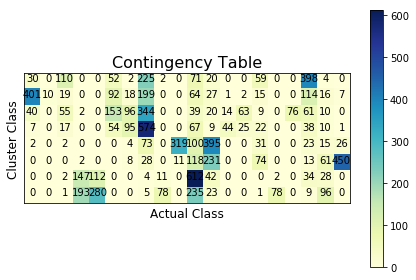

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.440783
Completeness Score: 0.354302
V-Measure Score: 0.392839
Adjusted Rand Index: 0.224145
Adjusted Mutual Information: 0.352149
n_components: 250
SVD complete after 2.594105 seconds
Finished clustering with 5 seeds in 1.227282 seconds
Show Contingency Matrix:


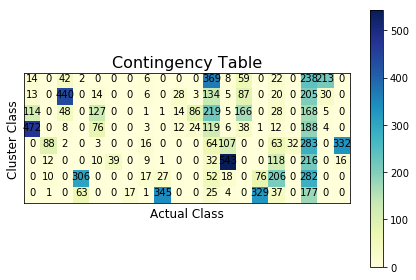

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.437042
Completeness Score: 0.355640
V-Measure Score: 0.392161
Adjusted Rand Index: 0.191393
Adjusted Mutual Information: 0.353459
n_components: 300
SVD complete after 3.276228 seconds
Finished clustering with 5 seeds in 1.499281 seconds
Show Contingency Matrix:


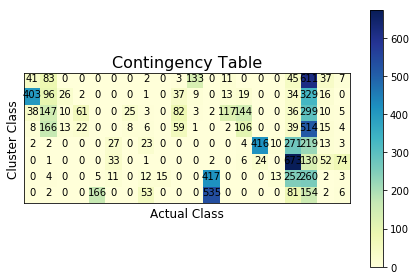

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.371627
Completeness Score: 0.345706
V-Measure Score: 0.358198
Adjusted Rand Index: 0.168711
Adjusted Mutual Information: 0.343159
n_components: 350
SVD complete after 3.852211 seconds
Finished clustering with 5 seeds in 1.833726 seconds
Show Contingency Matrix:


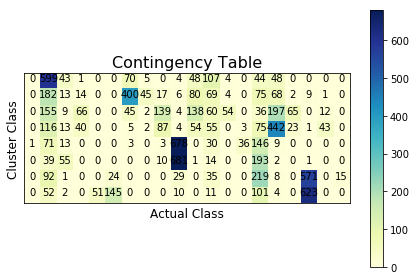

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.427246
Completeness Score: 0.372008
V-Measure Score: 0.397718
Adjusted Rand Index: 0.280324
Adjusted Mutual Information: 0.369779
n_components: 400
SVD complete after 4.541871 seconds
Finished clustering with 5 seeds in 2.072490 seconds
Show Contingency Matrix:


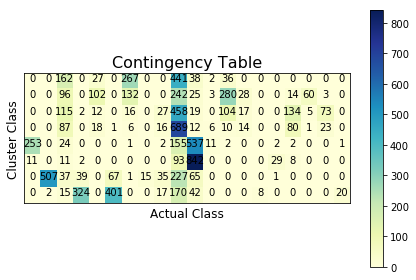

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.423049
Completeness Score: 0.394073
V-Measure Score: 0.408047
Adjusted Rand Index: 0.218431
Adjusted Mutual Information: 0.391677
n_components: 450
SVD complete after 5.188154 seconds
Finished clustering with 5 seeds in 2.132188 seconds
Show Contingency Matrix:


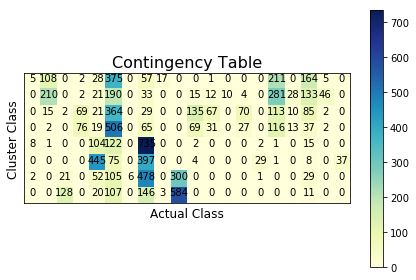

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.343562
Completeness Score: 0.325377
V-Measure Score: 0.334222
Adjusted Rand Index: 0.182190
Adjusted Mutual Information: 0.322647
n_components: 500
SVD complete after 6.154759 seconds
Finished clustering with 5 seeds in 2.375658 seconds
Show Contingency Matrix:


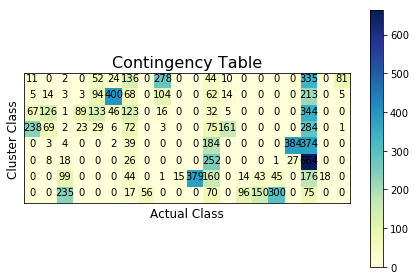

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.402084
Completeness Score: 0.339998
V-Measure Score: 0.368444
Adjusted Rand Index: 0.141020
Adjusted Mutual Information: 0.337671
n_components: 550
SVD complete after 6.840257 seconds
Finished clustering with 5 seeds in 2.840856 seconds
Show Contingency Matrix:


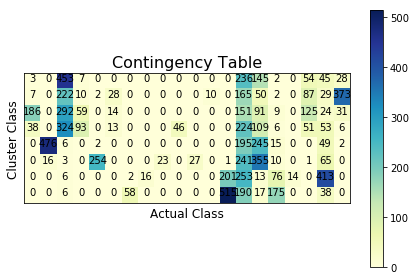

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.386444
Completeness Score: 0.337146
V-Measure Score: 0.360116
Adjusted Rand Index: 0.173770
Adjusted Mutual Information: 0.334682
n_components: 600
SVD complete after 7.647628 seconds
Finished clustering with 5 seeds in 3.167700 seconds
Show Contingency Matrix:


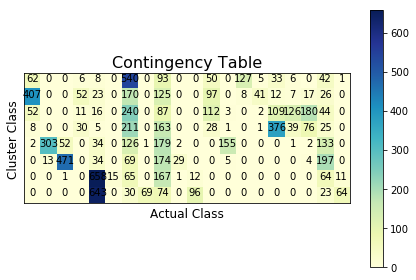

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.428546
Completeness Score: 0.357739
V-Measure Score: 0.389954
Adjusted Rand Index: 0.226834
Adjusted Mutual Information: 0.355509
n_components: 650
SVD complete after 8.334813 seconds
Finished clustering with 5 seeds in 3.349230 seconds
Show Contingency Matrix:


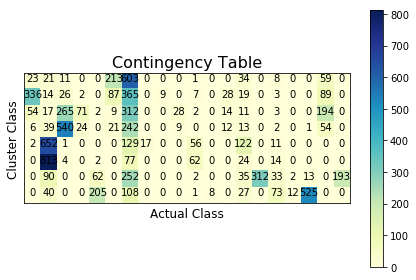

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.450039
Completeness Score: 0.407910
V-Measure Score: 0.427940
Adjusted Rand Index: 0.248276
Adjusted Mutual Information: 0.405621
n_components: 700
SVD complete after 9.145993 seconds
Finished clustering with 5 seeds in 3.649305 seconds
Show Contingency Matrix:


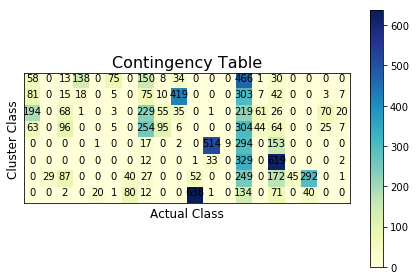

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.395962
Completeness Score: 0.352511
V-Measure Score: 0.372975
Adjusted Rand Index: 0.180815
Adjusted Mutual Information: 0.350088
n_components: 750
SVD complete after 11.957475 seconds
Finished clustering with 5 seeds in 3.770892 seconds
Show Contingency Matrix:


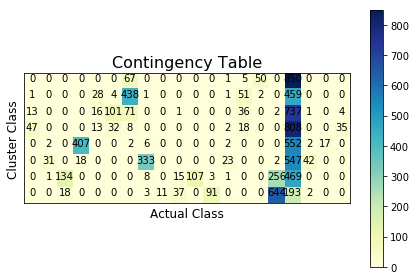

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.329846
Completeness Score: 0.420172
V-Measure Score: 0.369570
Adjusted Rand Index: 0.092651
Adjusted Mutual Information: 0.327002
n_components: 800
SVD complete after 13.161609 seconds
Finished clustering with 5 seeds in 4.294874 seconds
Show Contingency Matrix:


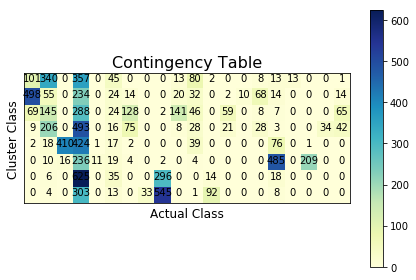

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.371919
Completeness Score: 0.352897
V-Measure Score: 0.362158
Adjusted Rand Index: 0.143342
Adjusted Mutual Information: 0.350289
n_components: 850
SVD complete after 14.316203 seconds
Finished clustering with 5 seeds in 4.325267 seconds
Show Contingency Matrix:


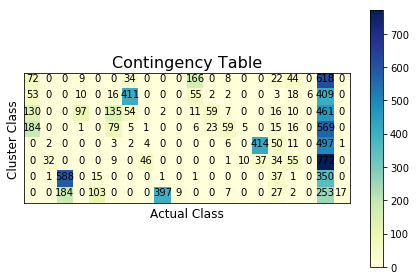

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.336356
Completeness Score: 0.361870
V-Measure Score: 0.348647
Adjusted Rand Index: 0.098921
Adjusted Mutual Information: 0.333526
n_components: 900
SVD complete after 16.682178 seconds
Finished clustering with 5 seeds in 4.636032 seconds
Show Contingency Matrix:


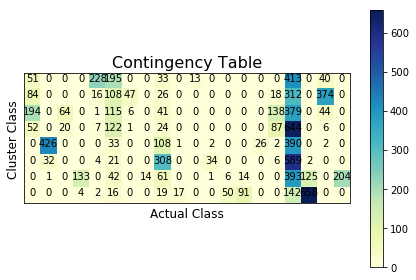

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.357296
Completeness Score: 0.350138
V-Measure Score: 0.353681
Adjusted Rand Index: 0.122614
Adjusted Mutual Information: 0.347435
n_components: 950
SVD complete after 19.183942 seconds
Finished clustering with 5 seeds in 5.011326 seconds
Show Contingency Matrix:


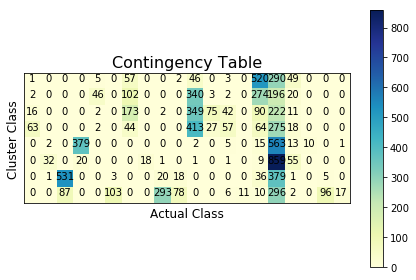

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.365702
Completeness Score: 0.369290
V-Measure Score: 0.367488
Adjusted Rand Index: 0.153103
Adjusted Mutual Information: 0.362996


In [34]:
nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_mutual_info = []
nmf_adjusted_rand_index = []

svd_homogeneity = []
svd_completeness = []
svd_v_measure = []
svd_adjusted_mutual_info = []
svd_adjusted_rand_index = []


for r in range(100,1000,50):
    print('n_components:',r)
    #DO NOT uncomment because NMF does not perform well when r>= 100
#     nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
#     k_means_nmf, km_nmf = k_means_clustering(nmf_dataset, dataset.target, n_clusters=20,random_state=0,max_iter=5,n_init=5, actual_class_names=[], cluster_class_names=[])
#     nmf_homogeneity.append(k_means_nmf['homogeneity'])
#     nmf_completeness.append(k_means_nmf['completeness'])
#     nmf_v_measure.append(k_means_nmf['v_measure'])
#     nmf_adjusted_mutual_info.append(k_means_nmf['adjusted_mutual_info'])
#     nmf_adjusted_rand_index.append(k_means_nmf['adjusted_rand_index'])
    
    svd_dataset,svd = svd_dimension_reduction(X_tfidf, n_components = r)
    k_means_svd, km_svd = k_means_clustering(svd_dataset, dataset.target, n_clusters=20,random_state=0,max_iter=5,n_init=5, actual_class_names=[], cluster_class_names=[])
    svd_homogeneity.append(k_means_svd['homogeneity'])
    svd_completeness.append(k_means_svd['completeness'])
    svd_v_measure.append(k_means_svd['v_measure'])
    svd_adjusted_mutual_info.append(k_means_svd['adjusted_mutual_info'])
    svd_adjusted_rand_index.append(k_means_svd['adjusted_rand_index'])

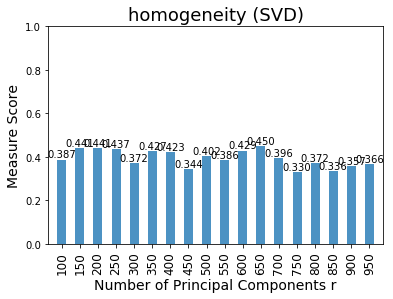

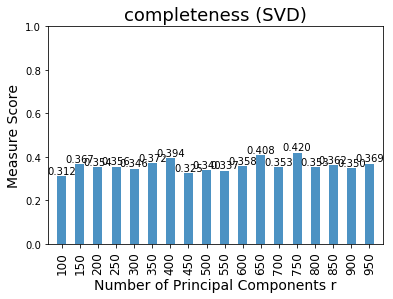

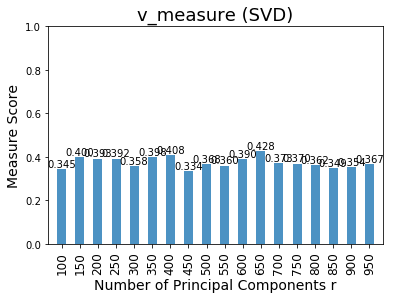

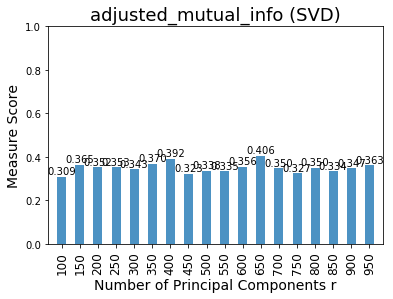

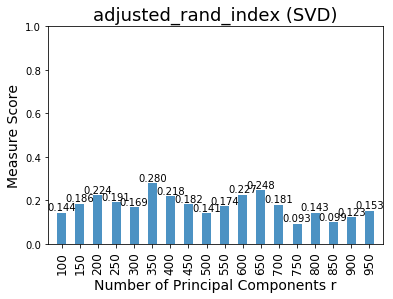

In [35]:

plot_histogram('SVD', 'homogeneity',svd_homogeneity, x_labels=range(100,1000,50), height=range(1,len(svd_homogeneity)+1),xtickangle=90)
plot_histogram('SVD', 'completeness',svd_completeness, x_labels=range(100,1000,50), height=range(1,len(svd_completeness)+1),xtickangle=90)
plot_histogram('SVD', 'v_measure',svd_v_measure, x_labels=range(100,1000,50), height=range(1,len(svd_v_measure)+1),xtickangle=90)
plot_histogram('SVD', 'adjusted_mutual_info',svd_adjusted_mutual_info, x_labels=range(100,1000,50), height=range(1,len(svd_adjusted_mutual_info)+1),xtickangle=90)
plot_histogram('SVD', 'adjusted_rand_index',svd_adjusted_rand_index, x_labels=range(100,1000,50), height=range(1,len(svd_adjusted_rand_index)+1),xtickangle=90)

In [36]:
# plot_histogram('NMF', 'homogeneity',nmf_homogeneity, x_labels=range(100,1000,50),height=range(1,len(nmf_homogeneity)+1),xtickangle=90)
# plot_histogram('NMF', 'completeness',nmf_completeness, x_labels=range(100,1000,50),height=range(1,len(nmf_completeness)+1),xtickangle=90)
# plot_histogram('NMF', 'v_measure',nmf_v_measure, x_labels=range(100,1000,50),height=range(1,len(nmf_v_measure)+1),xtickangle=90)
# plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info,x_labels=range(100,1000,50), height=range(1,len(nmf_adjusted_mutual_info)+1),xtickangle=90)
# plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index,x_labels=range(100,1000,50), height=range(1,len(nmf_adjusted_rand_index)+1),xtickangle=90)
               

n_components: 1
NMF complete after 0.181260 seconds
Finished clustering with 5 seeds in 0.073194 seconds
Show Contingency Matrix:


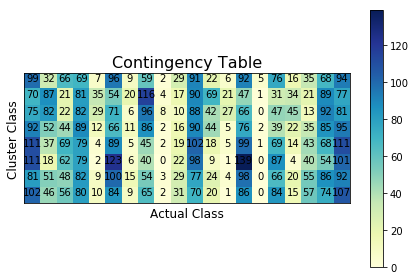

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.024188
Completeness Score: 0.018424
V-Measure Score: 0.020916
Adjusted Rand Index: 0.005223
Adjusted Mutual Information: 0.015312
n_components: 11
NMF complete after 0.980117 seconds
Finished clustering with 5 seeds in 0.105898 seconds
Show Contingency Matrix:


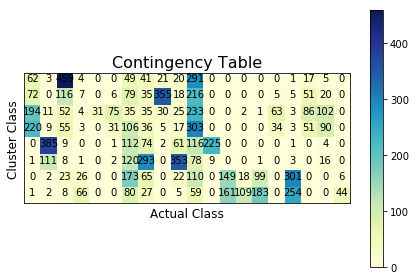

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.391297
Completeness Score: 0.302417
V-Measure Score: 0.341163
Adjusted Rand Index: 0.163472
Adjusted Mutual Information: 0.300197
n_components: 21
NMF complete after 3.107742 seconds
Finished clustering with 5 seeds in 0.123706 seconds
Show Contingency Matrix:


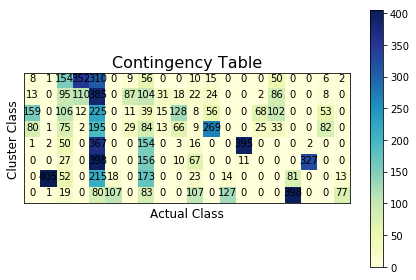

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.396807
Completeness Score: 0.320337
V-Measure Score: 0.354495
Adjusted Rand Index: 0.136227
Adjusted Mutual Information: 0.318084
n_components: 31
NMF complete after 10.109807 seconds
Finished clustering with 5 seeds in 0.139004 seconds
Show Contingency Matrix:


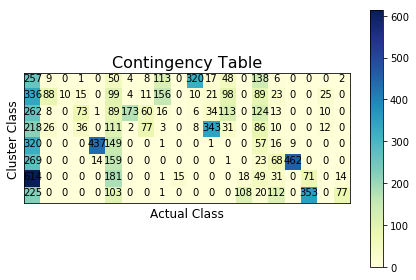

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.360131
Completeness Score: 0.309089
V-Measure Score: 0.332663
Adjusted Rand Index: 0.124490
Adjusted Mutual Information: 0.306608
n_components: 41
NMF complete after 12.090468 seconds
Finished clustering with 5 seeds in 0.149830 seconds
Show Contingency Matrix:


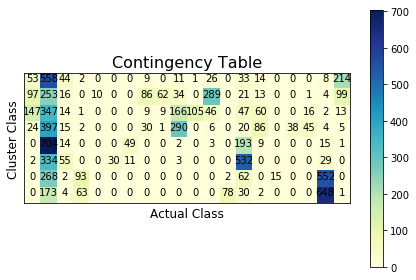

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.336731
Completeness Score: 0.332539
V-Measure Score: 0.334622
Adjusted Rand Index: 0.142331
Adjusted Mutual Information: 0.329759
n_components: 51
NMF complete after 29.839334 seconds
Finished clustering with 5 seeds in 0.196545 seconds
Show Contingency Matrix:


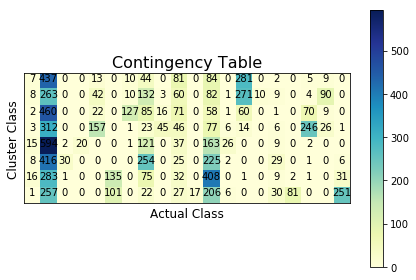

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.222715
Completeness Score: 0.219492
V-Measure Score: 0.221092
Adjusted Rand Index: 0.061211
Adjusted Mutual Information: 0.216236
n_components: 61
NMF complete after 40.316722 seconds
Finished clustering with 5 seeds in 0.195763 seconds
Show Contingency Matrix:


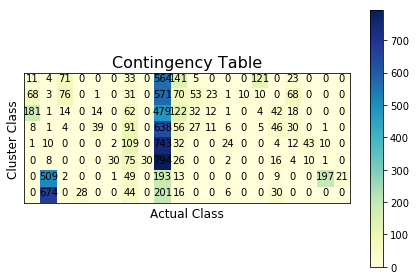

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.241002
Completeness Score: 0.284920
V-Measure Score: 0.261127
Adjusted Rand Index: 0.088728
Adjusted Mutual Information: 0.237782
n_components: 71
NMF complete after 53.791039 seconds
Finished clustering with 5 seeds in 0.238869 seconds
Show Contingency Matrix:


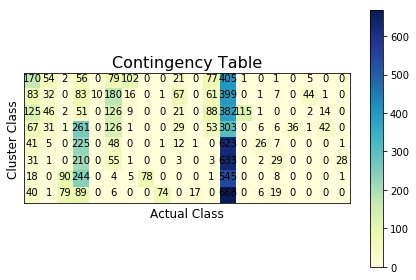

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.145208
Completeness Score: 0.165804
V-Measure Score: 0.154824
Adjusted Rand Index: 0.027884
Adjusted Mutual Information: 0.141593
n_components: 81
NMF complete after 54.289744 seconds
Finished clustering with 5 seeds in 0.260132 seconds
Show Contingency Matrix:


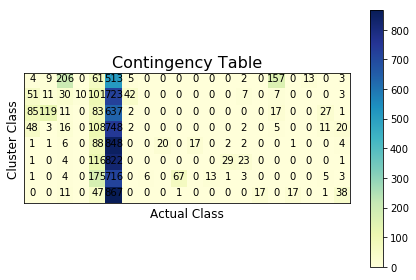

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.102821
Completeness Score: 0.193443
V-Measure Score: 0.134273
Adjusted Rand Index: 0.010977
Adjusted Mutual Information: 0.098860
n_components: 91
NMF complete after 84.155203 seconds
Finished clustering with 5 seeds in 0.294855 seconds
Show Contingency Matrix:


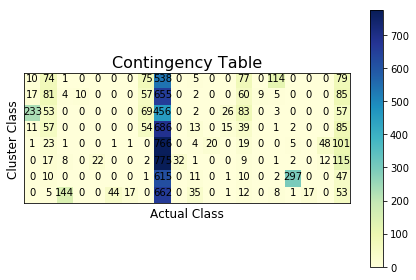

Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.147683
Completeness Score: 0.208458
V-Measure Score: 0.172885
Adjusted Rand Index: 0.018403
Adjusted Mutual Information: 0.143992


In [37]:
nmf_homogeneity = []
nmf_completeness = []
nmf_v_measure = []
nmf_adjusted_mutual_info = []
nmf_adjusted_rand_index = []

for r in range(1,100,10):
    print('n_components:',r)
    nmf_dataset,nmf = nmf_dimension_reduction(X_tfidf, n_components = r)
    k_means_nmf, km_nmf = k_means_clustering(nmf_dataset, dataset.target, n_clusters=20,random_state=0,max_iter=5,n_init=5, actual_class_names=[], cluster_class_names=[])
    nmf_homogeneity.append(k_means_nmf['homogeneity'])
    nmf_completeness.append(k_means_nmf['completeness'])
    nmf_v_measure.append(k_means_nmf['v_measure'])
    nmf_adjusted_mutual_info.append(k_means_nmf['adjusted_mutual_info'])
    nmf_adjusted_rand_index.append(k_means_nmf['adjusted_rand_index'])


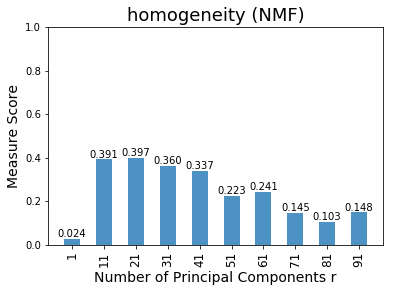

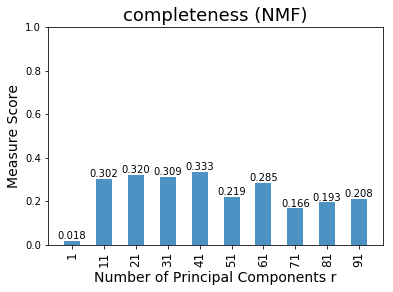

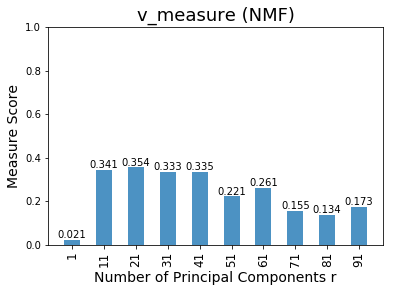

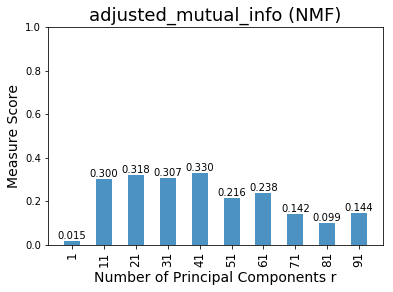

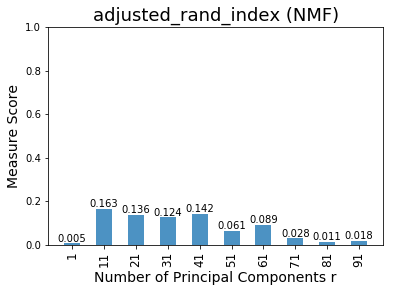

In [38]:
plot_histogram('NMF', 'homogeneity',nmf_homogeneity, x_labels=range(1,100,10),height=range(1,len(nmf_homogeneity)+1),xtickangle=90)
plot_histogram('NMF', 'completeness',nmf_completeness, x_labels=range(1,100,10),height=range(1,len(nmf_completeness)+1),xtickangle=90)
plot_histogram('NMF', 'v_measure',nmf_v_measure, x_labels=range(1,100,10),height=range(1,len(nmf_v_measure)+1),xtickangle=90)
plot_histogram('NMF', 'adjusted_mutual_info',nmf_adjusted_mutual_info,x_labels=range(1,100,10), height=range(1,len(nmf_adjusted_mutual_info)+1),xtickangle=90)
plot_histogram('NMF', 'adjusted_rand_index',nmf_adjusted_rand_index,x_labels=range(1,100,10), height=range(1,len(nmf_adjusted_rand_index)+1),xtickangle=90)
               

In [39]:
# transformation of 20 categories against best r values

In [40]:
C = 0.01

svd_best_r = 600
nmf_best_r = 21

svd_reduced, svd = svd_dimension_reduction(X_tfidf,svd_best_r)
nmf_reduced, temp = nmf_dimension_reduction(X_tfidf,nmf_best_r)

# Transformations on SVD reduced data
nonlinear_svd = nonlinear_transformation(svd_reduced)
scaled_svd = unit_variance_scale(svd_reduced)
nonlinear_scaled_svd = nonlinear_transformation(unit_variance_scale(svd_reduced))
scaled_nonlinear_svd = unit_variance_scale(nonlinear_transformation(svd_reduced))

# Transformations on NMF reduced data
nonlinear_nmf = nonlinear_transformation(nmf_reduced)
scaled_nmf = unit_variance_scale(nmf_reduced)
nonlinear_scaled_nmf = nonlinear_transformation(unit_variance_scale(nmf_reduced))
scaled_nonlinear_nmf = unit_variance_scale(nonlinear_transformation(nmf_reduced))

SVD complete after 7.648253 seconds
NMF complete after 2.859691 seconds



Results for Nonlinear SVD
Finished clustering with 5 seeds in 3.400065 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.387034
Completeness Score: 0.390830
V-Measure Score: 0.388922
Adjusted Rand Index: 0.253529
Adjusted Mutual Information: 0.384396


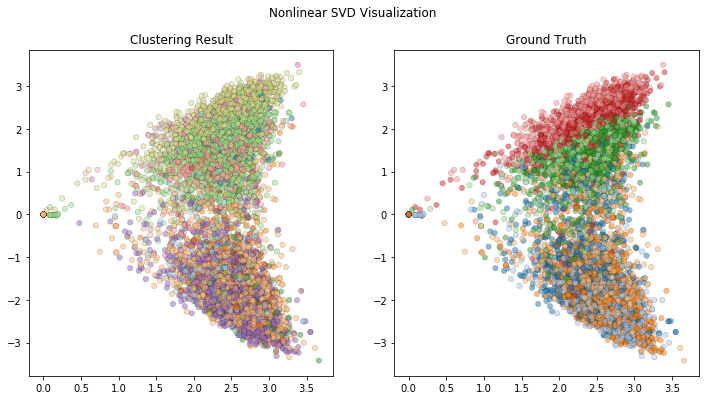


Results for Scaled SVD
Finished clustering with 5 seeds in 3.046252 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.060991
Completeness Score: 0.154113
V-Measure Score: 0.087395
Adjusted Rand Index: 0.004032
Adjusted Mutual Information: 0.056821


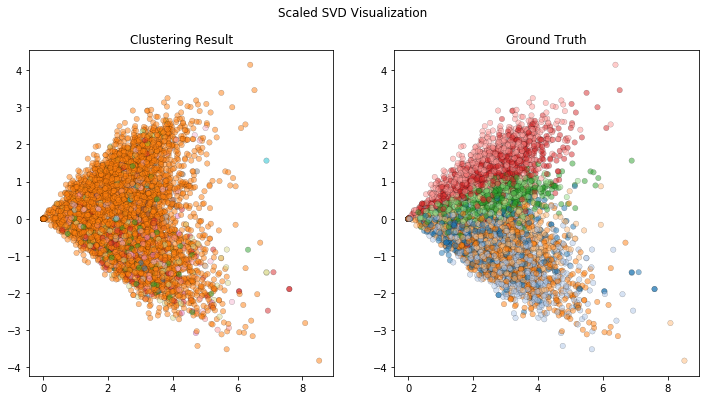


Results for Nonlinear of scaled SVD
Finished clustering with 5 seeds in 3.812240 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.155010
Completeness Score: 0.121367
V-Measure Score: 0.136141
Adjusted Rand Index: 0.048609
Adjusted Mutual Information: 0.118541


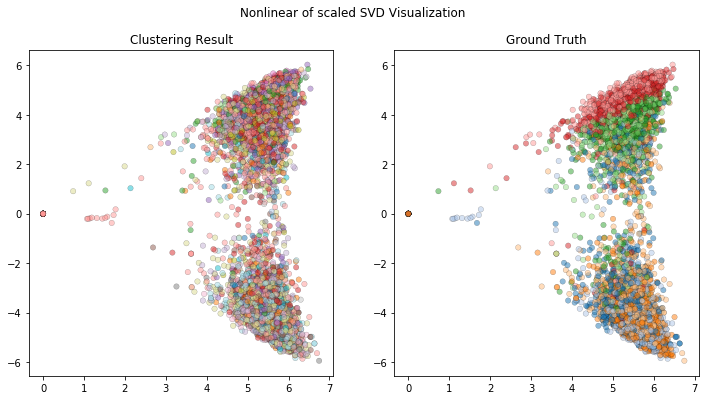


Results for Scaled nonlinear SVD
Finished clustering with 5 seeds in 3.367016 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.107201
Completeness Score: 0.104557
V-Measure Score: 0.105862
Adjusted Rand Index: 0.039458
Adjusted Mutual Information: 0.100821


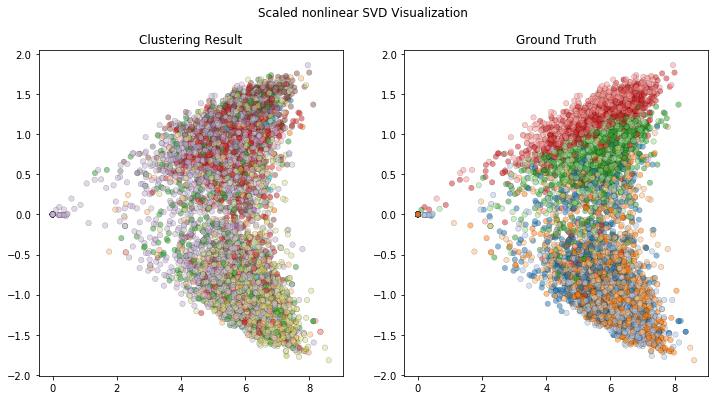


Results for Nonlinear NMF
Finished clustering with 5 seeds in 0.137735 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.466748
Completeness Score: 0.336779
V-Measure Score: 0.391252
Adjusted Rand Index: 0.248173
Adjusted Mutual Information: 0.334821


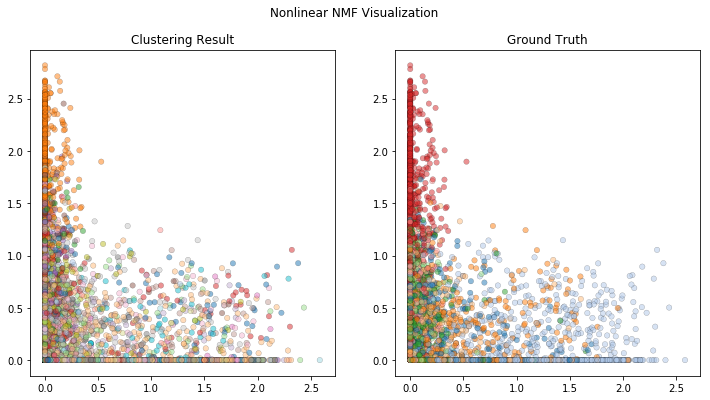


Results for Scaled NMF
Finished clustering with 5 seeds in 0.123218 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.414107
Completeness Score: 0.321757
V-Measure Score: 0.362137
Adjusted Rand Index: 0.151157
Adjusted Mutual Information: 0.319594


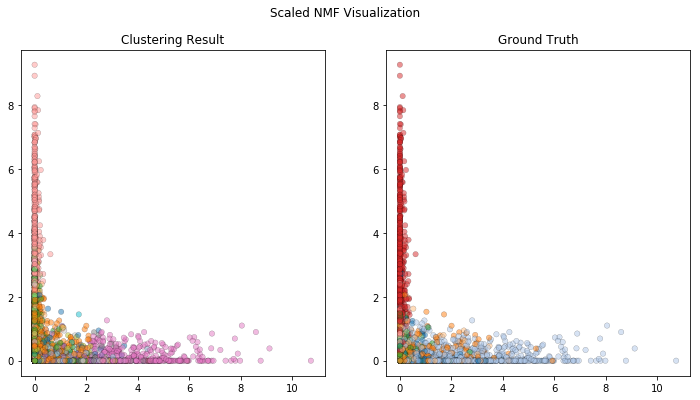


Results for Nonlinear of scaled NMF
Finished clustering with 5 seeds in 0.149745 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.425614
Completeness Score: 0.298723
V-Measure Score: 0.351054
Adjusted Rand Index: 0.186480
Adjusted Mutual Information: 0.296712


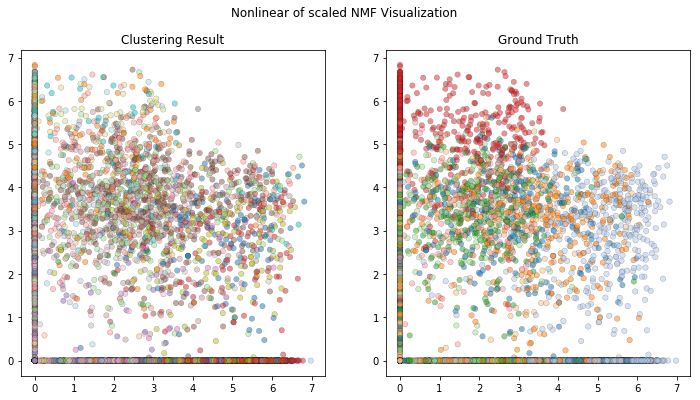


Results for Scaled nonlinear NMF
Finished clustering with 5 seeds in 0.133327 seconds
Show Contingency Matrix:
Report 5 Measures for K-Means Clustering
Homogeneity Score: 0.525831
Completeness Score: 0.377188
V-Measure Score: 0.439276
Adjusted Rand Index: 0.289059
Adjusted Mutual Information: 0.375361


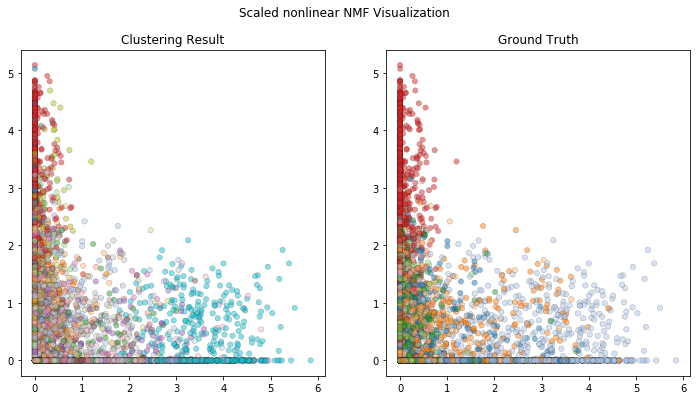

In [41]:

transformed_labels = ['Nonlinear SVD','Scaled SVD','Nonlinear of scaled SVD', 'Scaled nonlinear SVD',
                     'Nonlinear NMF', 'Scaled NMF','Nonlinear of scaled NMF', 'Scaled nonlinear NMF']

transformed_data = [nonlinear_svd, scaled_svd, nonlinear_scaled_svd, scaled_nonlinear_svd,
                   nonlinear_nmf, scaled_nmf, nonlinear_scaled_nmf, scaled_nonlinear_nmf]

transformed_homogeneity = []
transformed_completeness = []
transformed_v_measure = []
transformed_adj_mutual_info = []
transformed_adj_rand_index = []

# Cluster the transformed data
for i in range(len(transformed_labels)):
    print("\n===============================================")
    print("Results for " + transformed_labels[i])
    print("===============================================")

    results, k_means_object = k_means_clustering(transformed_data[i], dataset.target,
                                 n_clusters=20,random_state=0,max_iter=5,n_init=5, show_contin=False)
    transformed_homogeneity.append(results['homogeneity'])
    transformed_completeness.append(results['completeness'])
    transformed_v_measure.append(results['v_measure'])
    transformed_adj_mutual_info.append(results['adjusted_mutual_info'])
    transformed_adj_rand_index.append(results['adjusted_rand_index'])
    
    i_love_graphing_points(k_means_object, transformed_data[i], dataset.target, transformed_labels[i])